# Import Library

In [112]:
## import necessary library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Data upload and clean

In [40]:
## Function to clean and load data
def cleand_df(df, initial_month) : 
    df = pd.read_excel(df) ##read data
    df['finished_date'] = pd.to_datetime(df['finished_date']) ##change finished_date column to datetime category
    df = df.set_index('finished_date') ## set finished_date as index
    dfmonthly = df.resample('M').sum() ##resample from daily to monthly
    dfmonthly = dfmonthly.drop(['Unnamed: 0', 'no', 'sla'], axis=1) ## drop unneccesary columns
    dfmonthly = dfmonthly[initial_month:] ##split unneccesary months
    return dfmonthly

In [42]:
## clean and load data
dfmonthly = cleand_df(df = "Request Server With SLA Negative.xlsx", initial_month = 12)

# Visualize Data and Seasonal Decomposition

In [25]:
## Function to visualize data and seasonal decomposition
def visualize_and_seasonal_decompose(dfmonthly) :
    plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",) ## Visualize specification
    ax = dfmonthly.hdd.plot(title='bri', **plot_params)
    _ = ax.set(ylabel="hdd") ## visualize data
    from statsmodels.tsa.seasonal import seasonal_decompose ## import library for seasonal decompose
    plt.rc('figure',figsize=(14,8))
    plt.rc('font',size=15) ## visualize specification
    result = seasonal_decompose(dfmonthly.hdd,model='additive', period=4) ## seasonal decomposition
    fig = result.plot() ##visualize seasonel decomposition
    return _
    return fig
    return dfmonthly.head()


[Text(0, 0.5, 'hdd')]

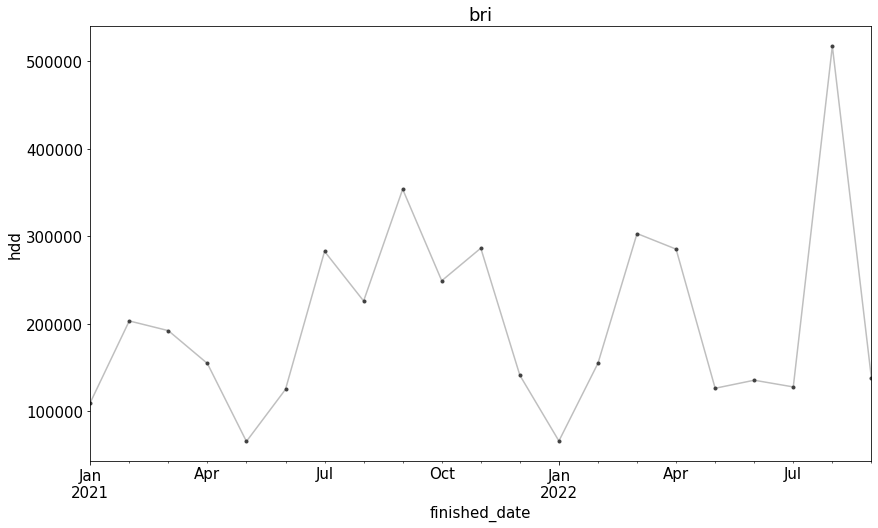

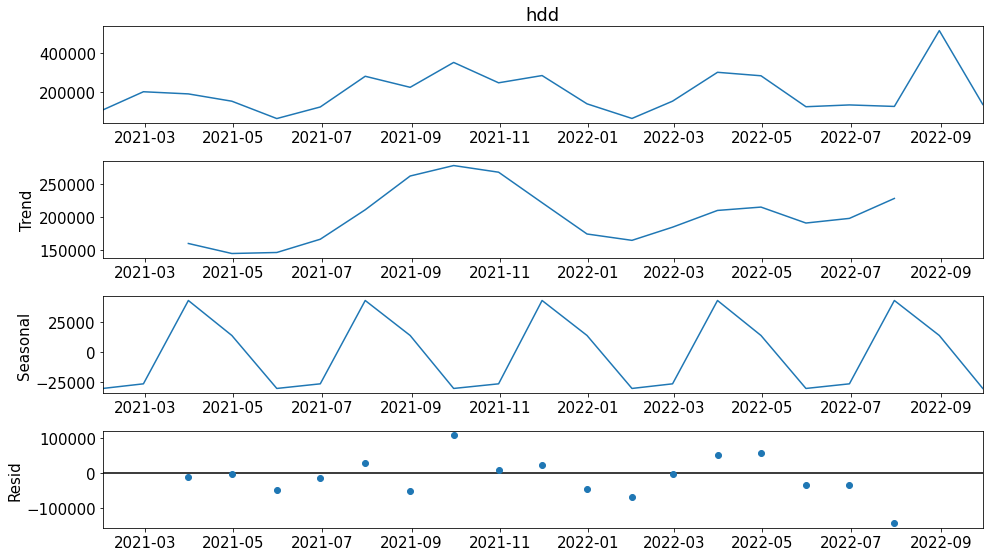

In [44]:
## execute visualize data and seasonal decomposition
visualize_and_seasonal_decompose(dfmonthly = dfmonthly)

# Outlier Detection

In [9]:
## function to plot outlier
def plot_outliers(outliers, data, method='KNN',
                  halignment = 'right',
                  valignment = 'bottom',
                  labels=False):
    ax = data.plot(alpha=0.6)
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}',
                     horizontalalignment=halignment,
                     verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
    
    plt.title(f'Resources - {method}')
    plt.xlabel('date'); plt.ylabel('# hdd')
    plt.legend(['hdd','outliers'])
    plt.show()

In [10]:
## function to determine outliers
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data[:] > upper_fence) | (data[:] < lower_fence)]

In [45]:
## determine outliers
outliers = iqr_outliers(dfmonthly.hdd)
outliers

finished_date
2022-08-31    517106
Freq: M, Name: hdd, dtype: int64

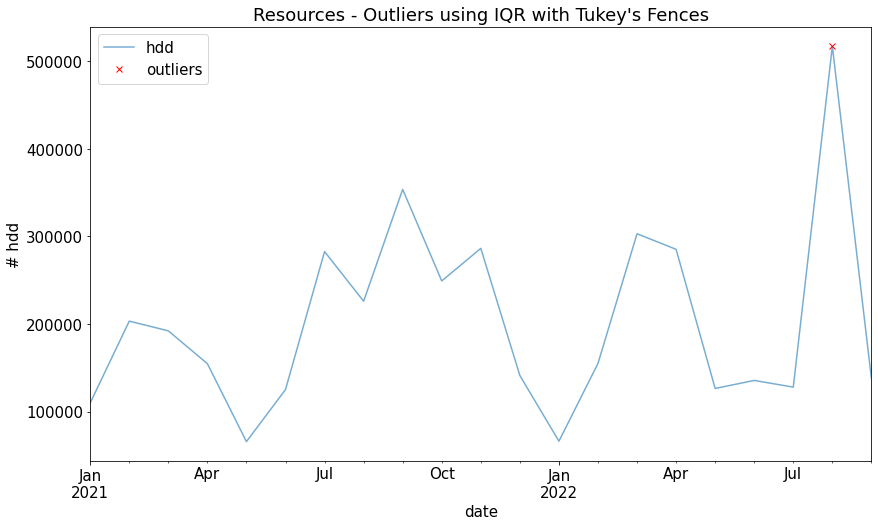

In [46]:
## plot outliers
plot_outliers(outliers, dfmonthly.hdd, "Outliers using IQR with Tukey's Fences")

In [47]:
#function to replace outliers
def normalize_outliers(dfmonthly, date1) :
    median = dfmonthly.hdd.median()
    dfmonthly.loc[date1, 'hdd'] = median
    return dfmonthly

In [48]:
## replace outliers
dfmonthly = normalize_outliers(dfmonthly = dfmonthly, date1 = '2022-08-31')

#### sources Tarek A. Atwan - Time Series Analysis with Python Cookbook_ Practical recipes for exploratory data analysis, data preparation, forecasting, and model evaluation-Packt Publishing (2022)

# Holtwinters Prediction

In [98]:
## function to split data and predict with holtwinters 
def predict_holtwinters(base, train_test, seasonal, forecast ) :
    # double and triple exponential smoothing
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    dfmonthlyhdd = base
    train = dfmonthlyhdd[:train_test]
    test = dfmonthlyhdd[train_test:]
    # Fit the model
    fitted_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=seasonal).fit()
    test_predictions = fitted_model.forecast(forecast)
    mape_holtwinter = np.mean(np.abs((test - test_predictions) / test)) * 100 
    return test_predictions, test, mape_holtwinter

In [99]:
## predict with holtwinters and make new variables(test dataframe and mape score)
predict, test, mape= predict_holtwinters(base = dfmonthly['hdd'], train_test = 18, seasonal= 4, forecast= 9)

C:\Users\L580\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [96]:
##function to plot holtwinter's prediction, original dataframe, and test dataframe
def plot_HW(base, test, prediction) : 
    plot_base = base.plot(legend=True,label='TRAIN')
    plot_test = test.plot(legend=True,label='TEST',figsize=(20,8))
    plot_predict = prediction.plot(legend=True,label='PREDICTIONadd')
    plt.title('Train, Test and Predicted data points using Holt Winters Exponential Smoothing')
    return plot_base, plot_test, plot_predict

(<AxesSubplot:title={'center':'Train, Test and Predicted data points using Holt Winters Exponential Smoothing'}, xlabel='finished_date'>,
 <AxesSubplot:title={'center':'Train, Test and Predicted data points using Holt Winters Exponential Smoothing'}, xlabel='finished_date'>,
 <AxesSubplot:title={'center':'Train, Test and Predicted data points using Holt Winters Exponential Smoothing'}, xlabel='finished_date'>)

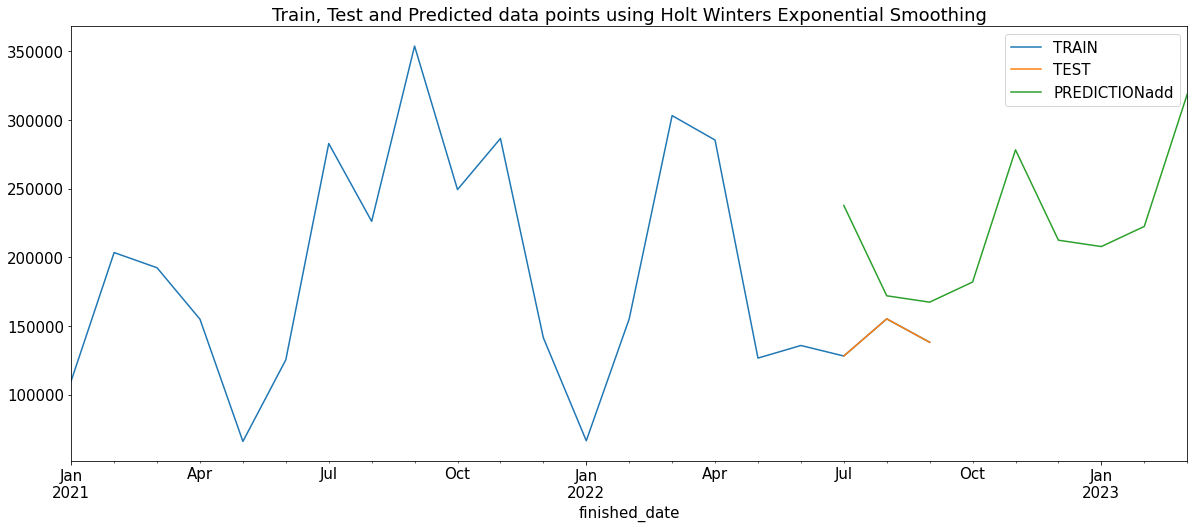

In [97]:
plot_HW(base = dfmonthly.hdd, test = test, prediction = predict)

In [101]:
## score of mean absolute percentage error
mape

39.20913326864508

# Predictions with XGBoost

In [102]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [103]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)

In [104]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [105]:
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(dfmonthly.hdd.copy())
data.columns = ["y"]

In [106]:
# Adding the lag of the target variable from 1 steps back  to 2
for i in range(1, 3):
    data["lag_{}".format(i)] = data.y.shift(i)

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [108]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [109]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.15)

In [110]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

C:\Users\L580\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\L580\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\L580\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\L580\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future ver

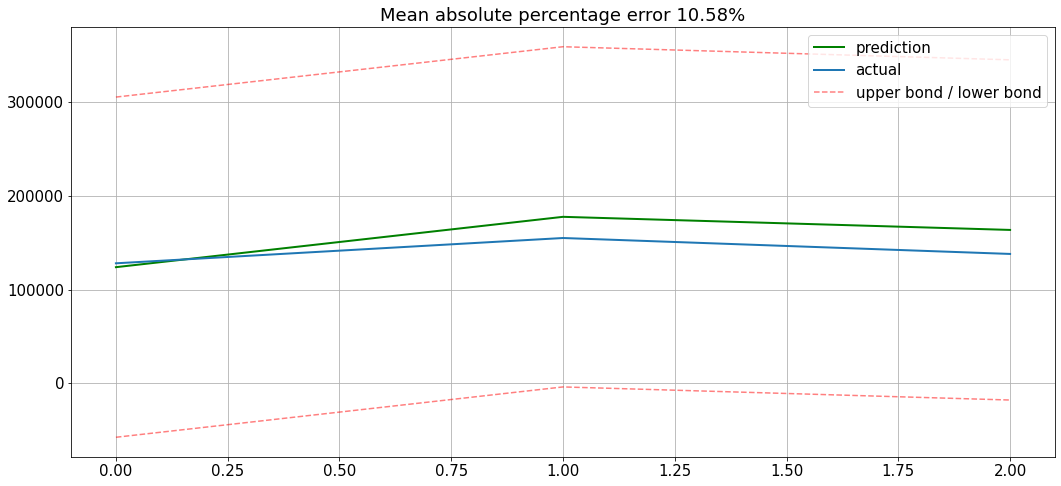

In [111]:
## Mean absolute error percentage of XGBReggressor
from xgboost import XGBRegressor

xgb = XGBRegressor(verbosity=0)
xgb.fit(X_train, y_train)
plotModelResults(xgb, plot_intervals=True)

#### sources from https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#triple-exponential-smoothing-a-k-a-holt-winters